## Quantum Memory Simulation - 3.0 - ORCA + Rydberg Storage

### Simulation Functions


In [23]:
%matplotlib inline

# Importing libraries

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
from tqdm.notebook import trange, tqdm
from IPython import display
import pylab as pl
import time

# Formatting plots and notebook outputs

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams["font.family"] = "serif"
plt.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [24]:
# Pulse Shape Functions

def exp_decay(t, t0, tau):
    """
    Exponential decay function.  Returns value at specified time.
    t0 = start time
    tau = characteristic 'decay' time - lifetime
    """
    A = np.sqrt(2/tau)
    if t < t0:
        return 0
    else:
        return A*np.exp(- (t-t0) / tau)

def gaussian(t, t0, tw, A):
    """
    Gaussian function. Returns value at specified time.
    tw = FWHM - pulse bandwidth is B = 0.44/tw - pulse duration t = 2.25*tw
    A = gaussian peak amplitude
    t0 = central time
    """
    sigma = tw/(2*np.sqrt(2*np.log(2)))
    gaussian = A*np.exp( - 0.5*((t-t0)/sigma)**2)
    return gaussian

def gaussianNorm(t, t0, tw):
    '''
    Gaussian funtion for the signal pulse. Input signal photon is a mode that must be normalised.
    '''
    sigma = tw/(2*np.sqrt(2*np.log(2)))
    amp = 1/(sigma*np.sqrt(2*np.pi))
    gaussian = amp*np.exp( - 0.5 * ((t-t0)/sigma)**2 )
    area = np.trapz(gaussian**2, t)
    gaussian = np.sqrt(L/c)*gaussian/np.sqrt(area)
    return gaussian


In [25]:
# Primary Simulation Functions

def init_coherences(Zlist, Tlist):
    '''
    Input the spatial grid z and the temporal grid t. Output the overall simulation matrices for
    the signal field, polarisation coherence, orbital-wave coherence and control field.
    '''
    #P = np.array([[0.0 for i in Zlist] for n in Tlist], dtype = "complex_")
    P = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    B = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    R = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    return P, B, R

def init_signal(Zlist, Tlist, shape, offset, pulsewidth):
    '''
    Input spatial grid z, temporal grid t and signal pulse-shape parameters. Output initial matrix
    for the signal field evolution.
    '''
    S = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    
    if shape == "zero":
        return S
    
    elif shape == "gaussian":
        S[:,0] = gaussianNorm(Tlist, offset, pulsewidth)
        return S

def init_control(initial, Zlist, Tlist, direction):
    '''
    Input spatial grid z, temporal grid t, and control pulse-shape parameters and direction. Output
    complete matrix for the control pulse evolution.
    '''
    if direction == "forward":
        Oc = np.array([initial[np.rint((t - tt0 - Zlist/c)/dt).astype(int)] for t in Tlist], dtype = "complex_")
        
    elif direction == "backward":
        Oc = np.array([initial[np.rint((t - tt0 + (Zlist-L)/c)/dt).astype(int)] for t in Tlist], dtype = "complex_")
        
    return Oc

def solve(S, P, B, R, Oc1, Oc2):
    '''
    Input signal field, polarisation coherence and orbital wave coherence matrices. Simulates storage process.
    Fourth order Runge-Kutta (RK4) in time. First order Euler backward in space.
    Output signal field, polarisation coherence and orbital wave coherence matrices after storage.
    '''
    for n in range(0, len(Tlist)-1):  
        S[n+1][1:] = (1-fo)*S[n][1:] + fo*S[n][:-1] + 1j*k*P[n][1:]*dt 
        
        p1 = P[n]
        p2 = P[n] + (dt/2)*p1
        p3 = P[n] + (dt/2)*p2
        p4 = P[n] + dt*p3
        P[n+1] = P[n] - (y2/2 - 1j*delta1)*(dt/6)*(p1 + 2*p2 + 2*p3 + p4) + 1j*k*S[n]*dt + 1j*Oc1[n]*B[n]*dt
        
        b1 = B[n]
        b2 = B[n] + (dt/2)*b1
        b3 = B[n] + (dt/2)*b2
        b4 = B[n] + dt*b3
        B[n+1] = B[n] - (y3/2 - 1j*delta2)*(dt/6)*(b1 + 2*b2 + 2*b3 + b4) + 1j*Oc1[n]*P[n]*dt + 1j*Oc2[n]*R[n]*dt
        
        r1 = R[n]
        r2 = R[n] + (dt/2)*r1
        r3 = R[n] + (dt/2)*r2
        r4 = R[n] + dt*r3
        R[n+1] = R[n] - (y4/2)*(dt/6)*(r1 + 2*r2 + 2*r3 + r4) + 1j*Oc2[n]*B[n]*dt
        
    return S, P, B, R

def calc_storage_efficiency(S, R):
    '''
    Check if the input signal field is normalised. Calculate the stored orbital-wave coherence and thus the
    storage efficiency.
    '''
    Sin = (c/L)*np.trapz(np.abs(S.transpose()[0])**2, Tlist)
    if round(Sin,3) != 1:
        return "Signal mode isn't normalised"
    else:
        Rout = (1/L)*np.trapz(np.abs(R[-1])**2, Zlist)
        return Rout

def init_retrieval(S, P, B, R, rev):
    '''
    Set coherences and signal field to zero. Set initial condition where the orbital-wave coherence is in the
    final state of the storage process.
    '''
    Sr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Pr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Br = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    Rr = np.zeros((len(Tlist), len(Zlist)), dtype = "complex_")
    if rev == 'reverse':  
        Rinit = R[-1][::-1]
        Rr[0] += Rinit
    elif rev == 'normal':
        Rinit = R[-1]
        Rr[0] += Rinit    
    return Sr, Pr, Br, Rr

def calc_total_efficiency(Sr, Rr):
    '''
    Calculate the energy in the output photonic mode (signal field). Since the input signal field is
    normalised, this output signal field represents the total memory efficiency. (Gorshkov)
    '''
    time_bin = int(round(2.25*tws/dt))
    Sout = (c/L)*np.trapz(np.abs(Sr.transpose()[-1][:time_bin])**2, Tlist[:time_bin])
    return Sout

def calc_overlap(control, signal):
    '''
    Used for pulse shaping, calculating the overlap between input and output signal pulses.
    '''
    overlap = np.array([min(control[n], signal[n]) for n in range(0,len(Tlist))])
    overlap_factor = np.trapz(overlap, Tlist)/np.trapz(signal, Tlist)
    return overlap_factor


#### Define simulation parameters - domain and discretisation

In [116]:
# SIMULATION PARAMETERS 

c = 300 # speed of light mm per ns

# TEMPORAL DOMAIN - ns
T0 = 0.0; T = 2.; tsteps = 2500
Tlist = np.linspace(T0, T, tsteps); dt = Tlist[1]-Tlist[0]; print('dt ', dt)

# Pulse Shape Initialisation domain - ns
tt0 = -2.; tt = 2.; ttsteps = 2*tsteps
ttlist = np.linspace(tt0, tt, ttsteps); dtt = Tlist[1]-Tlist[0]; print('dtt ', dtt)

# SPATIAL DOMAIN - mm
L0 = 0.0; L = 100; zsteps = 400
Zlist = np.linspace(L0, L, zsteps); dz = Zlist[1]-Zlist[0]; print('dz ', dz)

# Fourier number - stability check
fo = c*dt/dz; print('Fourier Number: ', fo)

dt  0.0008003201280512205
dtt  0.0008003201280512205
dz  0.2506265664160401
Fourier Number:  0.9579831932773111


#### Define atomic system parameters - detuning, decoherence rates, coupling strengths

In [140]:
# SYSTEM PARAMETERS 

delta1 = 6 # detuning - GHz
delta2 = 0

y2 = 1/29  # polarisation decoherence - GHz - 0.0328
y3 = 1/86  # orbital wave decoherence
y4 = 1/270 # GHz

d = 5000  # optical depth
k = np.sqrt((d*y2*c)/(2*L))  # coupling constant

#### Initialise atomic coherences and signal photon field

In [141]:
P, B, R = init_coherences(Zlist, Tlist)  # initialise coherences 

tws = 0.440; t0s = 2.25*tws/2;
S = init_signal(Zlist, Tlist, 'gaussian', t0s, tws)  # initialise signal field

#### Initialise storage control pulses

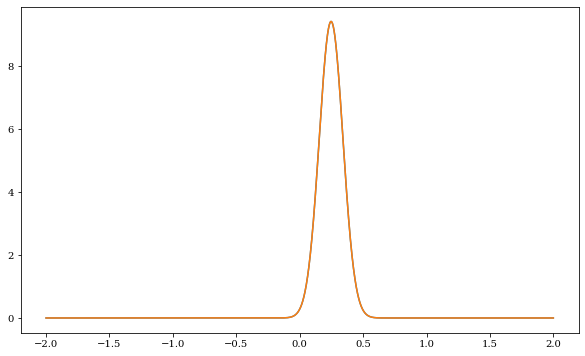

In [142]:
twc = 0.22; t0c = 2.25*twc/2; Oc0 = 3*np.pi
Oc1_init = gaussian(ttlist, t0c, twc, Oc0)
plt.plot(ttlist, Oc1_init)
Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')

Oc2_init = gaussian(ttlist, t0c, twc, Oc0)
plt.plot(ttlist, Oc2_init)
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

#### Solve storage simulation

In [143]:
S,P,B,R = solve(S,P,B,R,Oc1,Oc2)

#### Plot graphs and calculate storage efficiency

0.6565027665532606


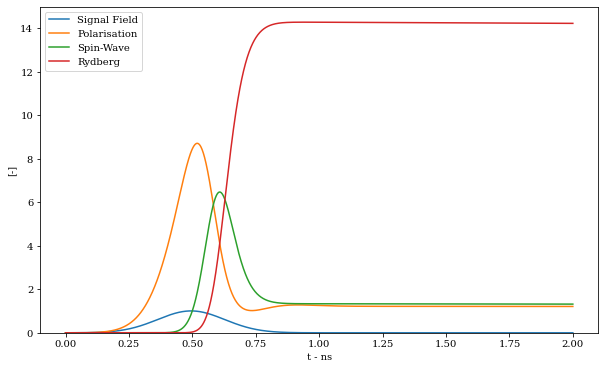

In [144]:
# Inspecting Graphs

nFoc = 0; 

St = S.transpose(); Pt = P.transpose(); Bt = B.transpose(); Rt = R.transpose()
Smax = max(np.abs(St[nFoc])**2); Pmax = max(np.abs(Pt[nFoc])**2); Bmax = max(np.abs(Bt[nFoc])**2); Rmax = max(np.abs(Rt[nFoc])**2)
plt.plot(Tlist, np.abs(St[nFoc])**2, label = 'Signal Field')
plt.plot(Tlist, np.abs(Pt[nFoc])**2, label = 'Polarisation')
plt.plot(Tlist, np.abs(Bt[nFoc])**2, label = 'Spin-Wave')
plt.plot(Tlist, np.abs(Rt[nFoc])**2, label = 'Rydberg')
#plt.plot(Tlist, 0.1*np.abs(Oct[nFoc])**2, '--', color='grey')
plt.xlabel('t - ns')
plt.ylabel('[-]')
plt.legend()
plt.ylim([0,None])
#plt.xlim([0,38])

efficiency = calc_storage_efficiency(S,R)
print(efficiency)

#### Prepare input to retrieval simulation

In [145]:
Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'reverse')

twc = 0.44; t0c = 2.25*twc/2; Oc0 = 3*np.pi
Ocr1_init = gaussian(ttlist, t0c, twc, Oc0)
Ocr1 = init_control(Ocr1_init, Zlist, Tlist, 'backward')  # initialise retrieval control field

Ocr2_init = gaussian(ttlist, t0c, twc, Oc0)
Ocr2 = init_control(Ocr2_init, Zlist, Tlist, 'backward')  # initialise retrieval control field 

#### Solve retrieval simulation

In [146]:
Sr, Pr, Br, Rr = solve(Sr, Pr, Br, Rr, Ocr1, Ocr2)

#### Plot graphs and calculate total memory efficiency

0.4151316225074114


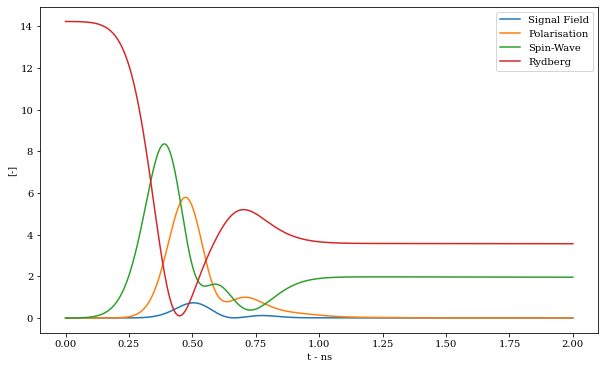

In [147]:
nFoc = -1; 

Str = Sr.transpose(); Ptr = Pr.transpose(); Btr = Br.transpose(); Rtr = Rr.transpose()
Smaxr = max(np.abs(Str[nFoc])**2); Pmaxr = max(np.abs(Ptr[nFoc])**2); Bmaxr = max(np.abs(Btr[nFoc])**2); Rmaxr = max(np.abs(Rtr[nFoc])**2) 
plt.plot(Tlist, np.abs(Str[nFoc])**2, label = 'Signal Field')
plt.plot(Tlist, np.abs(Ptr[nFoc])**2, label = 'Polarisation')
plt.plot(Tlist, np.abs(Btr[nFoc])**2, label = 'Spin-Wave')
plt.plot(Tlist, np.abs(Rtr[nFoc])**2, label = 'Rydberg')
plt.xlabel('t - ns')
plt.ylabel('[-]')
plt.legend()
#plt.ylim([0,None])
#plt.xlim([0,38])

total_efficiency = calc_total_efficiency(Sr, Rr)
print(total_efficiency)

#### Plot input and output signal pulses

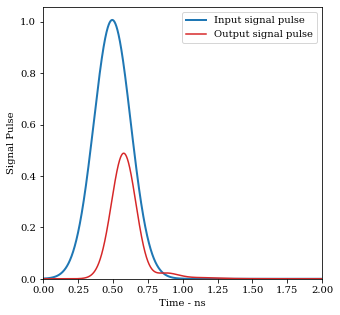

In [125]:
plt.plot(Tlist, np.abs(S.transpose()[0])**2, label="Input signal pulse", linewidth =2, color = "C0")
plt.plot(Tlist, np.abs(Sr.transpose()[-1])**2, label="Output signal pulse", color = "C3")
plt.xlim([0,2])
plt.ylim([0,None])
plt.xlabel("Time - ns")
plt.ylabel("Signal Pulse")
plt.legend()

Text(0, 0.5, 'Orbital-Wave')

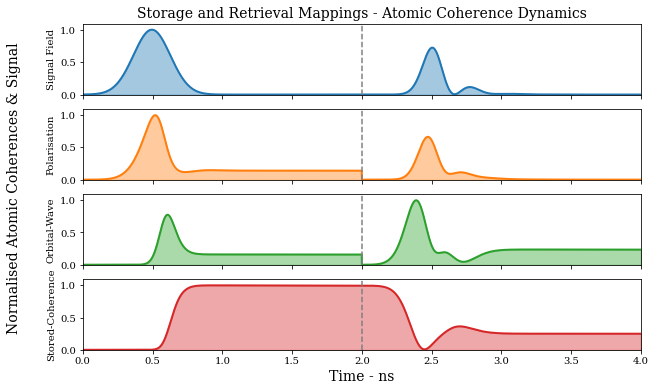

In [150]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

S_total = np.concatenate((S,Sr[:,::-1]))
P_total = np.concatenate((P,Pr[:,::-1]))
B_total = np.concatenate((B,Br[:,::-1]))
R_total = np.concatenate((R,Rr[:,::-1]))
Oc_total = np.concatenate((Oc1, Ocr1[:,::-1]))

T_total_list = np.linspace(0, 4, tsteps*2)

fig = plt.figure(1)

ax4 = plt.subplot(414)
plt.plot(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), 'C3', linewidth =2, label="Stored \nCoherence")
plt.fill_between(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), color="C3", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
#plt.legend()
plt.xlabel("Time - ns", fontsize = 14)
plt.ylabel("Stored-Coherence")
fig.supylabel("Normalised Atomic Coherences & Signal", fontsize = 14)

ax1 = plt.subplot(411, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(S_total)[0])**2, 'C0', linewidth =2, label="Signal")
plt.fill_between(T_total_list, np.abs(np.transpose(S_total)[0])**2, color="C0", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
#plt.legend()
plt.tick_params('x', labelbottom=False)
plt.ylabel("Signal Field")
plt.title("Storage and Retrieval Mappings - Atomic Coherence Dynamics", fontsize = 14)

ax2 = plt.subplot(412, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), 'C1', linewidth =2, label="Polarisation")
plt.fill_between(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), color="C1", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
#plt.legend()
plt.tick_params('x', labelbottom=False)
plt.ylabel("Polarisation")

ax3 = plt.subplot(413, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), 'C2', linewidth =2, label="Orbital \nWave")
plt.fill_between(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), color="C2", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 4])
plt.vlines([2], 0, 20, colors='grey', linestyles='dashed')
#plt.legend()
plt.tick_params('x', labelbottom=False)
plt.ylabel("Orbital-Wave")

#plt.savefig("memory-dynamics-%d.png" % tag, dpi=1200)

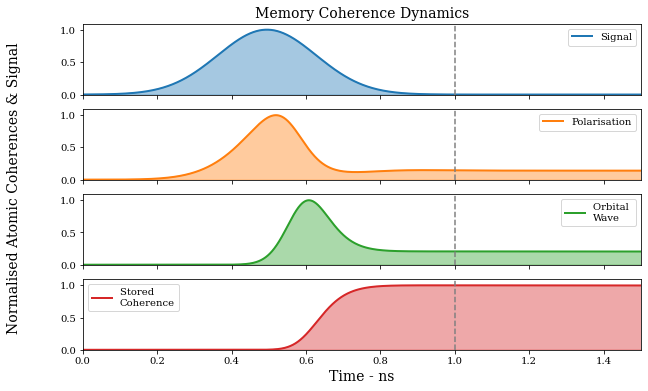

In [130]:
# ONLY STORAGE

import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

S_total = S
P_total = P
B_total = B
R_total = R

T_total_list = Tlist

fig = plt.figure(1)

ax4 = plt.subplot(414)
plt.plot(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), 'C3', linewidth =2, label="Stored \nCoherence")
plt.fill_between(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), color="C3", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.xlabel("Time - ns", fontsize = 14)
fig.supylabel("Normalised Atomic Coherences & Signal", fontsize = 14)

ax1 = plt.subplot(411, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(S_total)[0])**2, 'C0', linewidth =2, label="Signal")
plt.fill_between(T_total_list, np.abs(np.transpose(S_total)[0])**2, color="C0", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)
plt.title("Memory Coherence Dynamics", fontsize = 14)

ax2 = plt.subplot(412, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), 'C1', linewidth =2, label="Polarisation")
plt.fill_between(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), color="C1", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(413, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), 'C2', linewidth =2, label="Orbital \nWave")
plt.fill_between(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), color="C2", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

#plt.savefig("memory-dynamics-%d.png" % tag, dpi=1200)

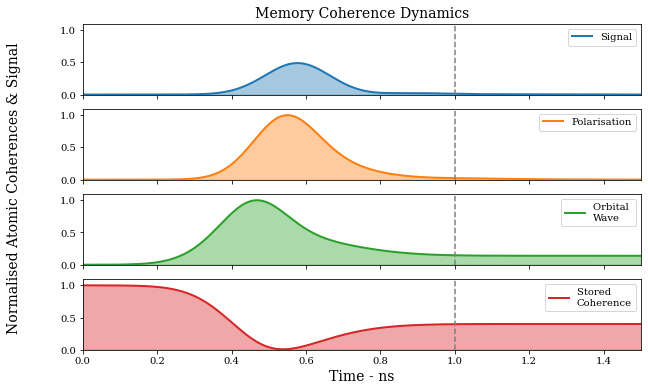

In [131]:
# ONLY RETRIEVAL

import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 6]

S_total = Sr[:,::-1]
P_total = Pr[:,::-1]
B_total = Br[:,::-1]
R_total = Rr[:,::-1]

T_total_list = Tlist

fig = plt.figure(1)

ax4 = plt.subplot(414)
plt.plot(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), 'C3', linewidth =2, label="Stored \nCoherence")
plt.fill_between(T_total_list, np.abs(np.transpose(R_total)[0])**2/max(np.abs(np.transpose(R_total)[0])**2), color="C3", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.xlabel("Time - ns", fontsize = 14)
fig.supylabel("Normalised Atomic Coherences & Signal", fontsize = 14)

ax1 = plt.subplot(411, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(S_total)[0])**2, 'C0', linewidth =2, label="Signal")
plt.fill_between(T_total_list, np.abs(np.transpose(S_total)[0])**2, color="C0", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)
plt.title("Memory Coherence Dynamics", fontsize = 14)

ax2 = plt.subplot(412, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), 'C1', linewidth =2, label="Polarisation")
plt.fill_between(T_total_list, np.abs(np.transpose(P_total)[0])**2/max(np.abs(np.transpose(P_total)[0])**2), color="C1", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax3 = plt.subplot(413, sharex = ax4)
plt.plot(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), 'C2', linewidth =2, label="Orbital \nWave")
plt.fill_between(T_total_list, np.abs(np.transpose(B_total)[0])**2/max(np.abs(np.transpose(B_total)[0])**2), color="C2", alpha=0.4)
plt.ylim([0, 1.1])
plt.xlim([0, 1.5])
plt.vlines([1,2], 0, 20, colors='grey', linestyles='dashed')
plt.legend()
plt.tick_params('x', labelbottom=False)

#plt.savefig("memory-dynamics-%d.png" % tag, dpi=1200)

In [ ]:
# Efficiency vs Optical Depth

delta1 = 6 # detuning - GHz
delta2 = 0

opticalDepths = np.linspace(1, 5000, 100)
storage_efficiencies = []
total_efficiencies = []
retrieval_efficiencies = []

tag = 1661771569 # storage eff = 0.971091955

control_pulse1_data = np.genfromtxt('storage-control-pulse-1-1000it-%d.csv' % tag, delimiter=',')
control_pulse2_data = np.genfromtxt('storage-control-pulse-2-1000it-%d.csv' % tag, delimiter=',')

Oc1_init = control_pulse1_data[1:,1]
Oc2_init = control_pulse2_data[1:,1]
Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

tag = 1661771576 # memory eff = 0.927982493

control_pulse1_data = np.genfromtxt('retrieval-control-pulse-1-1000it-%d.csv' % tag, delimiter=',')
control_pulse2_data = np.genfromtxt('retrieval-control-pulse-2-1000it-%d.csv' % tag, delimiter=',')

Oc1_init = control_pulse1_data[1:,1]
Oc2_init = control_pulse2_data[1:,1]
Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

for OD in tqdm(opticalDepths):
    d = OD  # optical depth
    k = np.sqrt((d*y2*c)/(2*L))  # coupling constant
    
    P, B, R = init_coherences(Zlist, Tlist)  # initialise coherences 
    
    tws = 0.440; t0s = 2.25*tws/2;
    S = init_signal(Zlist, Tlist, 'gaussian', t0s, tws)  # initialise signal field
    
    S,P,B,R = solve(S,P,B,R,Oc1,Oc2)
    
    storage_efficiency = calc_storage_efficiency(S,R)
    storage_efficiencies.append(storage_efficiency)
    
    Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'normal')
    
    Sr, Pr, Br, Rr = solve(Sr, Pr, Br, Rr, Ocr1, Ocr2)
    
    total_efficiency = calc_total_efficiency(Sr, Rr)
    total_efficiencies.append(total_efficiency)
    
    retrieval_efficiency = total_efficiency/storage_efficiency
    retrieval_efficiencies.append(retrieval_efficiency)
    
    
plt.plot(opticalDepths, storage_efficiencies)
plt.plot(opticalDepths, retrieval_efficiencies)
plt.plot(opticalDepths, total_efficiencies)
plt.xlim([0,5000])
plt.ylim([0,1])


  0%|          | 0/100 [00:00<?, ?it/s]

(0.0, 1.0)

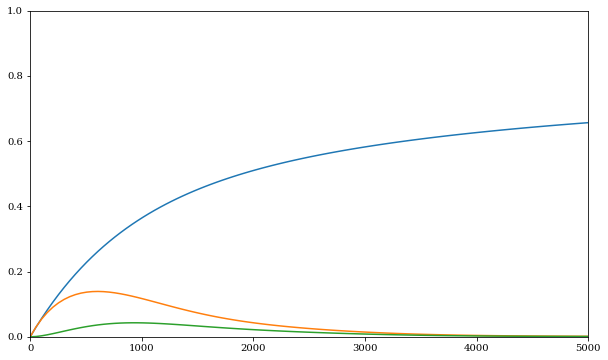

In [151]:
# Efficiency vs Optical Depth

delta1 = 6 # detuning - GHz
delta2 = 0

opticalDepths = np.linspace(1, 5000, 100)
storage_efficiencies = []
total_efficiencies = []
retrieval_efficiencies = []

twc = 0.22; t0c = 2.25*twc/2; Oc0 = 3*np.pi
Oc1_init = gaussian(ttlist, t0c, twc, Oc0)
Oc1 = init_control(Oc1_init, Zlist, Tlist, 'backward')

Oc2_init = gaussian(ttlist, t0c, twc, Oc0)
Oc2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

twc = 0.44; t0c = 2.25*twc/2; Oc0 = 3*np.pi
Ocr1_init = gaussian(ttlist, t0c, twc, Oc0)
Ocr1 = init_control(Ocr1_init, Zlist, Tlist, 'backward')  # initialise retrieval control field

Ocr2_init = gaussian(ttlist, t0c, twc, Oc0)
Ocr2 = init_control(Ocr2_init, Zlist, Tlist, 'backward')  # initialise retrieval control field 

tag = 1661771576 # memory eff = 0.927982493

control_pulse1_data = np.genfromtxt('retrieval-control-pulse-1-1000it-%d.csv' % tag, delimiter=',')
control_pulse2_data = np.genfromtxt('retrieval-control-pulse-2-1000it-%d.csv' % tag, delimiter=',')

Oc1_init = control_pulse1_data[1:,1]
Oc2_init = control_pulse2_data[1:,1]
Ocr1 = init_control(Oc1_init, Zlist, Tlist, 'backward')
Ocr2 = init_control(Oc2_init, Zlist, Tlist, 'backward')

for OD in tqdm(opticalDepths):
    d = OD  # optical depth
    k = np.sqrt((d*y2*c)/(2*L))  # coupling constant
    
    P, B, R = init_coherences(Zlist, Tlist)  # initialise coherences 
    
    tws = 0.440; t0s = 2.25*tws/2;
    S = init_signal(Zlist, Tlist, 'gaussian', t0s, tws)  # initialise signal field
    
    S,P,B,R = solve(S,P,B,R,Oc1,Oc2)
    
    storage_efficiency = calc_storage_efficiency(S,R)
    storage_efficiencies.append(storage_efficiency)
    
    Sr, Pr, Br, Rr = init_retrieval(S, P, B, R, 'normal')
    
    Sr, Pr, Br, Rr = solve(Sr, Pr, Br, Rr, Ocr1, Ocr2)
    
    total_efficiency = calc_total_efficiency(Sr, Rr)
    total_efficiencies.append(total_efficiency)
    
    retrieval_efficiency = total_efficiency/storage_efficiency
    retrieval_efficiencies.append(retrieval_efficiency)
    
    
plt.plot(opticalDepths, storage_efficiencies)
plt.plot(opticalDepths, retrieval_efficiencies)
plt.plot(opticalDepths, total_efficiencies)
plt.xlim([0,5000])
plt.ylim([0,1])
